In [ ]:
# A Retail store is open 6 days a week Mo - Sat.
# There are two eighthour shifts: Morning shift: 5:00 to 13:00, Evening shift is from 13:00 to 21:00.
# Each worker will not exceed a maximum of 40 hours per week.
# Everyone have to rest for 12 hours between two shifts.
# There are hired 10 full time employees.
# On Friday or Saturday we need 9 Workers per every day, Monday - Thursday 7 Workers per day is enough.
# Workforce metrics: Productivity rate, Labor utilization rate, Overtime rate, Absenteeism rate.

In [153]:
pip install pulp # 1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 75.9 MB/s eta 0:00:00


In [ ]:
%pip install -q amplpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 32.1 MB/s eta 0:00:00


In [ ]:
pip install pyworkforce # 2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.3 which is incompatible.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.

In [ ]:
from pyworkforce.scheduling import MinAbsDifference
from pprint import PrettyPrinter

In [ ]:
!pip install wfmplan # 3

In [ ]:
%pip install -q amplpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 19.7 MB/s eta 0:00:00


In [98]:
pip install pyomo # 4

In [ ]:
###############################################################

In [ ]:
# 1. Pulp - Objective: Calculate Extra resources needed

In [154]:
import pandas as pd
from pulp import *
import matplotlib.pyplot as plt
from itertools import chain, repeat

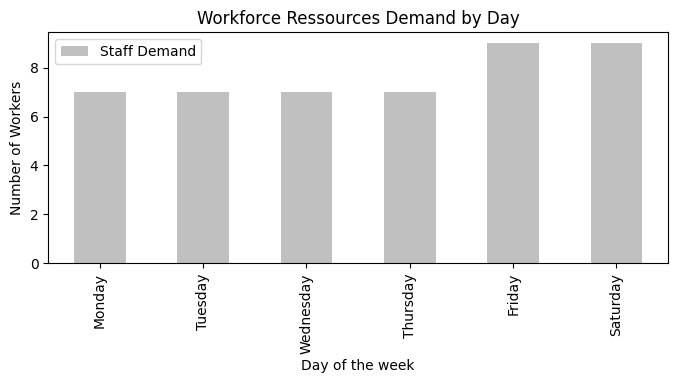

In [155]:
n_staff = [7, 7, 7, 7, 9, 9 ] # Staff Demand per Day (FTE)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Staff
df_staff = pd.DataFrame({'Days': days, 'Staff Demand':n_staff})
df_staff[['Days', 'Staff Demand']].plot.bar(x='Days', figsize = (8, 3), fill=True, color='silver')
plt.title('Workforce Ressources Demand by Day')
plt.xlabel('Day of the week')
plt.ylabel('Number of Workers')
plt.show()

In [156]:
# Returns the sequence elements n times
def ncycles(iterable, n):
    return chain.from_iterable(repeat(tuple(iterable), n))

# Create circular list of days
n_days = [i for i in range(6)]
n_days_c = list(ncycles(n_days, 3))

# Define 6 Working days
list_in = [[n_days_c[j] for j in range(i , i + 5)] for i in n_days_c]

# Define 4 Days off
list_excl = [[n_days_c[j] for j in range(i + 1, i + 3)] for i in n_days_c]

In [157]:
# The class has been initialize, and x, and days defined
model = LpProblem("Minimize Staffing", LpMinimize)

# Create Variables
start_days = ['Shift: ' + i for i in days]
x = LpVariable.dicts('shift_', n_days, lowBound=0, cat='Integer')

# Define Objective
model += lpSum([x[i] for i in n_days])

# Add constraints
for d, l_excl, staff in zip(n_days, list_excl, n_staff):
    model += lpSum([x[i] for i in n_days if i not in l_excl]) >= staff

# Solve Model
model.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[model.status])

Status: Optimal


/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [158]:
# How many workers per day ?
dct_work = {}
dico_work = {}
for v in model.variables():
    dct_work[int(v.name[-1])] = int(v.varValue)
    dico_work[v.name] = int(v.varValue)
dico_work

{'shift__0': 0,
 'shift__1': 3,
 'shift__2': 2,
 'shift__3': 2,
 'shift__4': 2,
 'shift__5': 3}

In [159]:
# Minimal total number of staff (including extra/back up resources)
dict_sch = {}
for day in dct_work.keys():
    dict_sch[day] = [dct_work[day] if i in list_in[day] else 0 for i in n_days]
df_sch = pd.DataFrame(dict_sch).T
df_sch.columns = days
df_sch.index = start_days
# The optimized objective function value is printed to the screen
print("Total number of Staff = ", pulp.value(model.objective))

Total number of Staff =  12.0


In [160]:
# Detailed: 0 Workers hired for Monday Shift
df_sch

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
Shift: Monday,0,0,0,0,0,0
Shift: Tuesday,0,3,3,3,3,3
Shift: Wednesday,2,0,2,2,2,2
Shift: Thursday,2,2,0,2,2,2
Shift: Friday,2,2,2,0,2,2
Shift: Saturday,3,3,3,3,0,3


In [161]:
# Sum by day - Supply
df_sch.sum(axis =0)

,0
Monday,9
Tuesday,10
Wednesday,10
Thursday,10
Friday,9
Saturday,12


In [162]:
df_supp = df_staff.copy().set_index('Days')
df_supp['Staff Supply'] = df_sch.sum(axis = 0)
df_supp['Extra_Ressources'] = df_supp['Staff Supply'] - df_supp['Staff Demand']
df_supp.to_csv('test.csv')

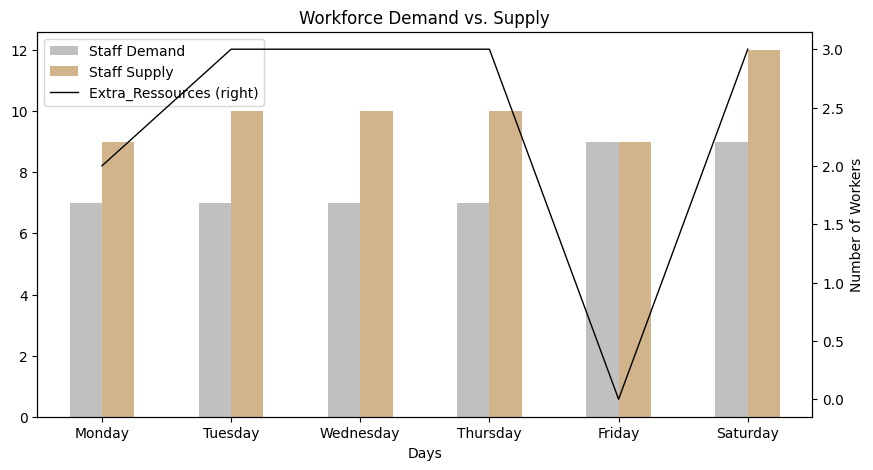

In [165]:
# Staff
ax = df_supp.plot.bar(y=['Staff Demand', 'Staff Supply'], figsize = (10, 5), fill=True, color=['silver', 'tan'])
df_supp.plot(y=['Extra_Ressources'], color=['black'], secondary_y = True, ax = ax, linewidth = 1)
plt.title('Workforce Demand vs. Supply')
plt.xlabel('Day of the week')
plt.ylabel('Number of Workers')
plt.show()

In [ ]:
# 2. Amplpy - Objective: Create Workplan

In [ ]:
# install dependencies and select solver
%pip install -q amplpy matplotlib

SOLVER = "highs"

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://ampl.com/colab).


In [ ]:
%%writefile shift_schedule.mod

# avaiable workers
set WORKERS ordered;
# ordered sets of days and shifts
set DAYS ordered;
set SHIFTS ordered;
# set of day, shift time slots
set SLOTS within {DAYS, SHIFTS};
# set of 24 hour time blocks
set BLOCKS within {SLOTS, SLOTS, SLOTS};
# set of weekend shifts
set WEEKENDS within SLOTS;

# parameters
# number of workers required for each slot
param WorkersRequired{SLOTS};
# max hours per week per worker
param Hours;
# weight of the weekend component in the objective function
param gamma default 0.1;

# variables
# assign[worker, day, shift] = 1 assigns worker to a time slot
var assign{WORKERS, SLOTS} binary;
# weekend[worker] = 1 worker is assigned weekend shift
var weekend{WORKERS} binary;
# needed[worker] = 1
var needed{WORKERS} binary;


# assign a sufficient number of workers for each time slot
s.t. required_workers {(day, shift) in SLOTS}:
    WorkersRequired[day, shift] == sum{worker in WORKERS} assign[worker, day, shift];

# workers limited to forty hours per week assuming 8 hours per shift
s.t. forty_hour_limit {worker in WORKERS}:
    8 * sum{(day, shift) in SLOTS} assign[worker, day, shift] <= Hours;

# workers are assigned no more than one time slot per 24 time block
s.t. required_rest {worker in WORKERS, (d1, s1, d2, s2, d3, s3) in BLOCKS}:
    assign[worker, d1, s1] + assign[worker, d2, s2] + assign[worker, d3, s3] <= 1;

# determine if a worker is assigned to any shift
s.t. is_needed {worker in WORKERS}:
    sum{(day, shift) in SLOTS} assign[worker, day, shift] <= card(SLOTS) * needed[worker];

# determine if a worker is assigned to a weekend shift
s.t. is_weekend {worker in WORKERS}:
    6 * weekend[worker] >= sum{(day, shift) in WEEKENDS} assign[worker, day, shift];

# weighted version: since we are minimizing the objective function a smaller weight will give higher
# priority to a given worker
# weight is obtained with the ord function, that returns the index of a given worker in the weights SET
minimize minimize_workers:
    sum{worker in WORKERS} ord(worker) * needed[worker] +
    gamma * sum{worker in WORKERS} ord(worker) * weekend[worker];

Overwriting shift_schedule.mod


In [ ]:
# Set the number of total available workers and conditions ( if no worker has vacation or no worker sick)
# 10 Workers, maximum 40 Workhours per week
def shift_schedule(N=10, hours=40):
    """return a solved model assigning N workers to shifts"""
    workers = [f"W{i:02d}" for i in range(1, N + 1)]
    days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
    shifts = ["morning", "afternoon", "night"]
    slots = [(d, s) for d in days for s in shifts]
    blocks = [(slots[i] + slots[i + 1] + slots[i + 2]) for i in range(len(slots) - 2)]
    weekends = [(d, s) for (d, s) in slots if d in ["Sat", "Sun"]]
    workers_required = {
        (d, s): (0 if s in ["night"] else
                 3 if s in ["morning"] and d in ["Mon","Tue", "Wed","Thu"] else
                 4 if s in ["morning"] and d in ["Fri","Sat"] else
                 4 if s in ["afternoon"] and d in ["Mon","Tue", "Wed","Thu"] else
                 5 if s in ["afternoon"] and d in ["Fri","Sat"] else
                 0)
        for d in days
        for s in shifts
    }

    m = AMPL()
    m.read("shift_schedule.mod")

    m.set["WORKERS"] = workers
    m.set["DAYS"] = days
    m.set["SHIFTS"] = shifts
    m.set["SLOTS"] = slots
    m.set["BLOCKS"] = blocks
    m.set["WEEKENDS"] = weekends
    m.param["WorkersRequired"] = workers_required
    m.param["Hours"] = hours

    m.option["solver"] = SOLVER
    m.solve()

    return m

# Currently available workers
m = shift_schedule(10, 40)

HiGHS 1.7.1: HiGHS 1.7.1: optimal solution; objective 59.5
466 simplex iterations
1 branching nodes


<ipython-input-34-4fda7e4fac2e>:44: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Rectangle((i, j + (1 - bw) / 2), 1, bw, color="k", edgecolor="k"))


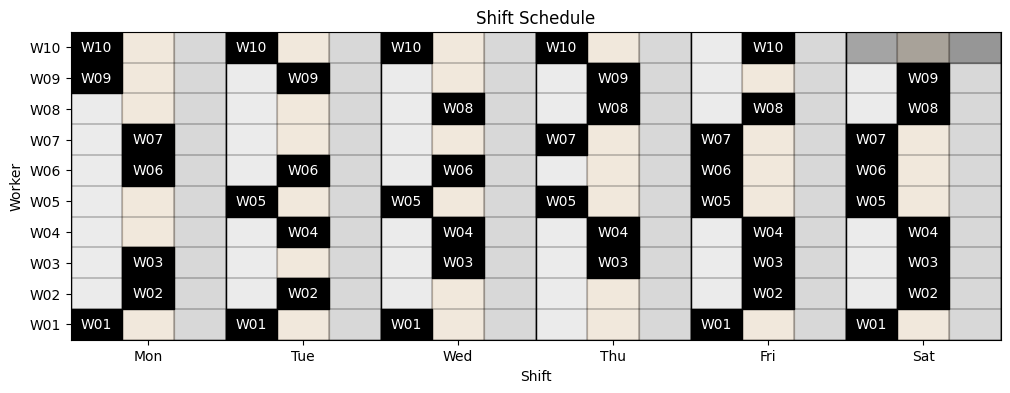

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize(m):
    workers = m.set["WORKERS"].to_list()
    slots = m.set["SLOTS"].to_list()
    days = m.set["DAYS"].to_list()

    assign = m.var["assign"].to_dict()
    needed = m.var["needed"].to_dict()
    weekend = m.var["weekend"].to_dict()

    bw = 1.0
    fig, ax = plt.subplots(1, 1, figsize=(12, 1 + 0.3 * len(workers)))
    ax.set_title("Shift Schedule")

    # x axis styling
    ax.set_xlim(0, len(slots))
    colors = ["silver", "tan", "grey"]
    for i in range(len(slots) + 1):
        ax.axvline(i, lw=0.3, color="k")
        ax.fill_between(
            [i, i + 1], [0] * 2, [len(workers)] * 2, alpha=0.3, edgecolor="k", color=colors[i % 3]
        )
    for i in range(len(days) + 1):
        ax.axvline(3 * i, lw=1, color="k")
    ax.set_xticks([3 * i + 1.5 for i in range(len(days))])
    ax.set_xticklabels(days)
    ax.set_xlabel("Shift")

    # y axis styling
    ax.set_ylim(0, len(workers))
    for j in range(len(workers) + 1):
        ax.axhline(j, lw=0.3, color="k")
    ax.set_yticks([j + 0.5 for j in range(len(workers))])
    ax.set_yticklabels(workers)
    ax.set_ylabel("Worker")

    # show shift assignments
    for i, slot in enumerate(slots):
        day, shift = slot
        for j, worker in enumerate(workers):
            if round(assign[worker, day, shift]):
                ax.add_patch(Rectangle((i, j + (1 - bw) / 2), 1, bw, color="k", edgecolor="k"))
                ax.text(
                    i + 1 / 2, j + 1 / 2, worker, ha="center", va="center", color="w"
                )

    # display needed and weekend data
    for j, worker in enumerate(workers):
        if not needed[worker]:
            ax.fill_between(
                [0, len(slots)], [j, j], [j + 1, j + 1], color="k", alpha=0.3
            )
        if needed[worker] and not weekend[worker]:
            ax.fill_between(
                [15, len(slots)], [j, j], [j + 1, j + 1], color="k", alpha=0.3
            )


visualize(m)

In [ ]:
import pandas as pd

# get the schedule from AMPL and convert to pandas DataFrame with defined columns
schedule = m.var["assign"].to_list()
schedule = pd.DataFrame(
    [[s[0], s[1], s[2]] for s in schedule if s[3]], columns=["worker", "day", "shift"]
)

# create and assign a worker category type
worker_type = pd.CategoricalDtype(
    categories=m.set["WORKERS"].to_list(), ordered=True
)
schedule["worker"] = schedule["worker"].astype(worker_type)

# create and assign a day category type
day_type = pd.CategoricalDtype(
    categories=m.set["DAYS"].to_list(), ordered=True
)
schedule["day"] = schedule["day"].astype(day_type)

# create and assign a shift category type
shift_type = pd.CategoricalDtype(
    categories=m.set["SHIFTS"].to_list(), ordered=True
)
schedule["shift"] = schedule["shift"].astype(shift_type)

# demonstrate sorting and display of the master schedule
schedule.sort_values(by=["day", "shift", "worker"])

,worker,day,shift
1,W01,Mon,morning
37,W09,Mon,morning
42,W10,Mon,morning
6,W02,Mon,afternoon
10,W03,Mon,afternoon
25,W06,Mon,afternoon
30,W07,Mon,afternoon
3,W01,Tue,morning
22,W05,Tue,morning
44,W10,Tue,morning


In [ ]:
# sort schedule by worker
schedule = schedule.sort_values(by=["worker", "day", "shift"])

# print worker schedules
for worker, worker_schedule in schedule.groupby("worker"):
    print(f"\n Work schedule for {worker}")
    if len(worker_schedule) > 0:
        for s in worker_schedule.to_string(index=False).split("\n"):
            print(s)
    else:
        print("   no assigned shifts")


 Work schedule for W01
worker day   shift
   W01 Mon morning
   W01 Tue morning
   W01 Wed morning
   W01 Fri morning
   W01 Sat morning

 Work schedule for W02
worker day     shift
   W02 Mon afternoon
   W02 Tue afternoon
   W02 Fri afternoon
   W02 Sat afternoon

 Work schedule for W03
worker day     shift
   W03 Mon afternoon
   W03 Wed afternoon
   W03 Thu afternoon
   W03 Fri afternoon
   W03 Sat afternoon

 Work schedule for W04
worker day     shift
   W04 Tue afternoon
   W04 Wed afternoon
   W04 Thu afternoon
   W04 Fri afternoon
   W04 Sat afternoon

 Work schedule for W05
worker day   shift
   W05 Tue morning
   W05 Wed morning
   W05 Thu morning
   W05 Fri morning
   W05 Sat morning

 Work schedule for W06
worker day     shift
   W06 Mon afternoon
   W06 Tue afternoon
   W06 Wed afternoon
   W06 Fri   morning
   W06 Sat   morning

 Work schedule for W07
worker day     shift
   W07 Mon afternoon
   W07 Thu   morning
   W07 Fri   morning
   W07 Sat   morning

 Work schedule 

<ipython-input-37-93a763b35ff7>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for worker, worker_schedule in schedule.groupby("worker"):


In [ ]:
# sort by day, shift, worker
schedule = schedule.sort_values(by=["day", "shift", "worker"])

for day, day_schedule in schedule.groupby("day"):
    print(f"\nShift schedule for {day}")
    for shift, shift_schedule in day_schedule.groupby("shift"):
        print(f"   {shift} shift: ", end="")
        print(", ".join([worker for worker in shift_schedule["worker"].values]))


Shift schedule for Mon
   morning shift: W01, W09, W10
   afternoon shift: W02, W03, W06, W07
   night shift: 

Shift schedule for Tue
   morning shift: W01, W05, W10
   afternoon shift: W02, W04, W06, W09
   night shift: 

Shift schedule for Wed
   morning shift: W01, W05, W10
   afternoon shift: W03, W04, W06, W08
   night shift: 

Shift schedule for Thu
   morning shift: W05, W07, W10
   afternoon shift: W03, W04, W08, W09
   night shift: 

Shift schedule for Fri
   morning shift: W01, W05, W06, W07
   afternoon shift: W02, W03, W04, W08, W10
   night shift: 

Shift schedule for Sat
   morning shift: W01, W05, W06, W07
   afternoon shift: W02, W03, W04, W08, W09
   night shift: 


<ipython-input-38-741c50def949>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for day, day_schedule in schedule.groupby("day"):
<ipython-input-38-741c50def949>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for shift, shift_schedule in day_schedule.groupby("shift"):


In [ ]:
# 3. pyworkforce - Objective: Calculate total Workforce Cost
# minimize the total scheduled resources while not planning fewer resources than required for each interval

In [ ]:
from pyworkforce.scheduling import MinRequiredResources
from pprint import PrettyPrinter

# Resources needed
# Columns are an hour of the day, rows are the days
# N_dp
required_resources = [
    [1, 1, 1, 1, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 1, 1, 1],
    [1, 1, 1, 1, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 1, 1, 1],
    [1, 1, 1, 1, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 1, 1, 1],
    [1, 1, 1, 1, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 1, 1, 1],
    [1, 1, 1, 1, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 1, 1, 1],
    [1, 1, 1, 1, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 1, 1, 1],
    [1, 1, 1, 1, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 1, 1, 1]
]

# Supply of Resources
# Each entry of a shift, is an hour of the day (24 columns)
# E_sp
shifts_coverage = {"Morning": [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   "Afternoon": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                   "Night": [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
                   "Mixed": [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]}

# The cost of shifting a resource if each shift, if present, solver will minimize the total cost
# C_s
cost_dict = {"Morning": 1, "Afternoon": 1.2, "Night": 2, "Mixed": 1.5}

scheduler = MinRequiredResources(num_days=7,  # S
                                 periods=24,  # P
                                 shifts_coverage=shifts_coverage,
                                 required_resources=required_resources,
                                 max_period_concurrency=27,  # gamma
                                 max_shift_concurrency=25)   # beta

solution = scheduler.solve()
pp = PrettyPrinter(indent=2)
pp.pprint(solution)

{ 'cost': 97.0,
  'resources_shifts': [ {'day': 0, 'resources': 4, 'shift': 'Morning'},
                        {'day': 0, 'resources': 3, 'shift': 'Afternoon'},
                        {'day': 0, 'resources': 4, 'shift': 'Night'},
                        {'day': 0, 'resources': 3, 'shift': 'Mixed'},
                        {'day': 1, 'resources': 4, 'shift': 'Morning'},
                        {'day': 1, 'resources': 3, 'shift': 'Afternoon'},
                        {'day': 1, 'resources': 4, 'shift': 'Night'},
                        {'day': 1, 'resources': 2, 'shift': 'Mixed'},
                        {'day': 2, 'resources': 4, 'shift': 'Morning'},
                        {'day': 2, 'resources': 3, 'shift': 'Afternoon'},
                        {'day': 2, 'resources': 4, 'shift': 'Night'},
                        {'day': 2, 'resources': 2, 'shift': 'Mixed'},
                        {'day': 3, 'resources': 4, 'shift': 'Morning'},
                        {'day': 3, 'resources': 3, 'sh

In [ ]:
# 3.A. - wfmplan - Objective: calculate the optimal number of workers for various scenarios

# Retail Store
# calculate the optimal number of workers required to meet ASA and SLA targets for expected incoming clients ( applicable in scenarios such as call centers, customer support, live chat, retail stores, and help desks )
# reduce wait times, and improve operational efficiency
# calculate the number of agents required based on:
# expected customer volume
# aht (average handling time, in seconds, e.g. 5 minutes per client or 4 minutes per client )
# interval (in seconds, 3600 Seconds = 1 Hour)
# SLA (service level agreement in seconds)
# ASA (average speed of answer in seconds) targets.
# run optimization for a DataFrame containing multiple scenarios
# account for maximum occupancy (agent req) and shrinkage (agent req shrink)
# SLA: in simple terms, it's a number of calls answered for a certain time, for example, 80% within 20 seconds or 85% for 15. This is a more stable and reliable indicator.

from wfmplan.AgentOptimizer import Optimizer

# Scenario Empty Shop, Quality Focus SLA
optimizer = Optimizer(exp_vol=50, aht=300, interval=3600, method='SLA', SLA=20)
# Get the predicted agent requirements
result = optimizer.predict()
print(result)

# Scenario Busy Shop, Quality Focus SLA
optimizer = Optimizer(exp_vol=100, aht=300, interval=3600, method='SLA', SLA=20) # 80% answered within 20 seconds
# Get the predicted agent requirements
result = optimizer.predict()
print(result)

# Scenario Busy Shop, Performance Focus, understaffed ASA
optimizer = Optimizer(exp_vol=100, aht=300, interval=3600, method='asa', asa=20)
# Get the predicted agent requirements
result = optimizer.predict()
print(result)

# Scenario Crowded Shop, Performance Focus, understaffed ASA
optimizer = Optimizer(exp_vol=150, aht=240, interval=3600, method='asa', asa=20)
# Get the predicted agent requirements
result = optimizer.predict()
print(result)

# Scenario Overcrowded Shop, Performance Focus, understaffed ASA
optimizer = Optimizer(exp_vol=200, aht=240, interval=3600, method='asa', asa=20)
# Get the predicted agent requirements
result = optimizer.predict()
print(result)

{'agent_req': 5, 'agent_req_shrink': 5, 'pred_occupancy': 0.83, 'prob_waiting': 0.6140824974737136}
{'agent_req': 9, 'agent_req_shrink': 9, 'pred_occupancy': 0.93, 'prob_waiting': 0.7603082548106046}
{'agent_req': 12, 'agent_req_shrink': 12, 'pred_occupancy': 0.69, 'prob_waiting': 0.17593271530827165, 'pred_asa': 14.4}
{'agent_req': 14, 'agent_req_shrink': 14, 'pred_occupancy': 0.71, 'prob_waiting': 0.17412438131098773, 'pred_asa': 10.4}
{'agent_req': 17, 'agent_req_shrink': 17, 'pred_occupancy': 0.78, 'prob_waiting': 0.2573109628207927, 'pred_asa': 16.8}


In [ ]:
# 3.B. - wfmplan - Objective: calculate the optimal number of workers for various scenarios, shrink and occupancy
# 1 interval = 4 hours ( = 240 minutes = 14 400 seconds )
# exp aht - expected average handling time (in seconds)
# shrinkage - the percent of worker paid time that is spent not with Client, but by other work ( e.g. paperwork, set up, cleaning, maintenace, ... )
# occupancy - the percent of worker paid time that is spent directly with Client
from wfmplan.AgentOptimizer import BatchOptimizer
import pandas as pd

# Define
df = pd.DataFrame({
    'exp_vol': [250, 500, 1000],
    'exp_aht': [300, 200, 250],
    'interval_start': pd.to_datetime(['2024-08-21 08:00:00', '2024-08-21 12:00:00', '2024-08-21 16:00:00']),
    'interval_end': pd.to_datetime(['2024-08-21 12:00:00', '2024-08-21 16:00:00', '2024-08-21 20:00:00'])
})

# Define your Focus
operational_targets = {
    'max_occupancy': 0.7, # Worker spends 70% with Front Line Client, 30% another utilisation
    'shrink': 0.3, # Worker must spend minimum 30% of time not with Client
    'SLA': 20,
    'method': 'SLA'
}

batch_optimizer = BatchOptimizer(df, operational_targets)
result_df = batch_optimizer.run_optimization()

print(result_df)

       interval_start        interval_end  exp_vol  exp_aht  agent_req  \
0 2024-08-21 08:00:00 2024-08-21 12:00:00      250      300          8   
1 2024-08-21 12:00:00 2024-08-21 16:00:00      500      200         10   
2 2024-08-21 16:00:00 2024-08-21 20:00:00     1000      250         25   

   agent_req_shrink  pred_occupancy  prob_waiting  
0                12            0.65      0.198628  
1                15            0.69      0.213167  
2                36            0.69      0.058825  


In [ ]:
# 4. Pyomo

In [ ]:
pip install pyomo

In [ ]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))
from pyomo.environ import *
from pyomo.gdp import *

In [147]:
TASKS = {
    ('Worker1','Project1')   : {'dur': 6, 'prec': None},
    ('Worker1','Project3') : {'dur': 2, 'prec': ('Worker1','Project1')},
    ('Worker2','Project1')   : {'dur': 4, 'prec': ('Worker2','Project2')},
    ('Worker2','Project2')  : {'dur': 2, 'prec': None},
    ('Worker2','Project3') : {'dur': 3, 'prec': ('Worker2','Project1')},
    ('Worker3','Project1')   : {'dur': 3, 'prec': ('Worker3','Project3')},
    ('Worker3','Project2')  : {'dur': 2, 'prec': ('Worker3','Project1')},
    ('Worker3','Project3') : {'dur': 3, 'prec': None},
}

In [148]:
def jobshop_model(TASKS):

    model = ConcreteModel()

    # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)

    # the set of jobs is constructed from a python set
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.TASKS])))

    # set of machines is constructed from a python set
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.TASKS])))

    # the order of tasks is constructed as a cross-product of tasks and filtering
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4,
        filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])

    # the set of disjunctions is cross-product of jobs, jobs, and machines
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)

    # load duration data into a model parameter for later access
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j,m)]['dur'])

    # establish an upper bound on makespan
    ub = sum([model.dur[j, m] for (j,m) in model.TASKS])

    # create decision variables
    model.makespan = Var(bounds=(0, ub))
    model.start = Var(model.TASKS, bounds=(0, ub))

    model.objective = Objective(expr = model.makespan, sense = minimize)

    model.finish = Constraint(model.TASKS, rule=lambda model, j, m:
        model.start[j,m] + model.dur[j,m] <= model.makespan)

    model.preceding = Constraint(model.TASKORDER, rule=lambda model, j, m, k, n:
        model.start[k,n] + model.dur[k,n] <= model.start[j,m])

    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + model.dur[j,m] <= model.start[k,m],
         model.start[k,m] + model.dur[k,m] <= model.start[j,m]])

    TransformationFactory('gdp.hull').apply_to(model)
    return model

jobshop_model(TASKS)

In [150]:
def jobshop_solve(model):
    SolverFactory('cbc').solve(model)
    results = [{'Worker Name': j,
                'Project Name': m,
                'Start': model.start[j, m](),
                'Duration': model.dur[j,m],
                'End': model.start[(j, m)]() + model.dur[j,m]}
               for j,m in model.TASKS]
    return results

def jobshop(TASKS):
    return jobshop_solve(jobshop_model(TASKS))

results = jobshop(TASKS)
results

[{'Worker Name': 'Worker1',
  'Project Name': 'Project1',
  'Start': 0.0,
  'Duration': 6,
  'End': 6.0},
 {'Worker Name': 'Worker1',
  'Project Name': 'Project3',
  'Start': 13.0,
  'Duration': 2,
  'End': 15.0},
 {'Worker Name': 'Worker2',
  'Project Name': 'Project1',
  'Start': 6.0,
  'Duration': 4,
  'End': 10.0},
 {'Worker Name': 'Worker2',
  'Project Name': 'Project2',
  'Start': 0.0,
  'Duration': 2,
  'End': 2.0},
 {'Worker Name': 'Worker2',
  'Project Name': 'Project3',
  'Start': 10.0,
  'Duration': 3,
  'End': 13.0},
 {'Worker Name': 'Worker3',
  'Project Name': 'Project1',
  'Start': 10.0,
  'Duration': 3,
  'End': 13.0},
 {'Worker Name': 'Worker3',
  'Project Name': 'Project2',
  'Start': 13.0,
  'Duration': 2,
  'End': 15.0},
 {'Worker Name': 'Worker3',
  'Project Name': 'Project3',
  'Start': 0.0,
  'Duration': 3,
  'End': 3.0}]

In [151]:
schedule = pd.DataFrame(results)

print('\nSchedule by Worker')
print(schedule.sort_values(by=['Worker Name','Start']).set_index(['Worker Name', 'Project Name']))

print('\nSchedule by Project')
print(schedule.sort_values(by=['Project Name','Start']).set_index(['Project Name', 'Worker Name']))


Schedule by Worker
                          Start  Duration   End
Worker Name Project Name                       
Worker1     Project1        0.0         6   6.0
            Project3       13.0         2  15.0
Worker2     Project2        0.0         2   2.0
            Project1        6.0         4  10.0
            Project3       10.0         3  13.0
Worker3     Project3        0.0         3   3.0
            Project1       10.0         3  13.0
            Project2       13.0         2  15.0

Schedule by Project
                          Start  Duration   End
Project Name Worker Name                       
Project1     Worker1        0.0         6   6.0
             Worker2        6.0         4  10.0
             Worker3       10.0         3  13.0
Project2     Worker2        0.0         2   2.0
             Worker3       13.0         2  15.0
Project3     Worker3        0.0         3   3.0
             Worker2       10.0         3  13.0
             Worker1       13.0         2  15.0

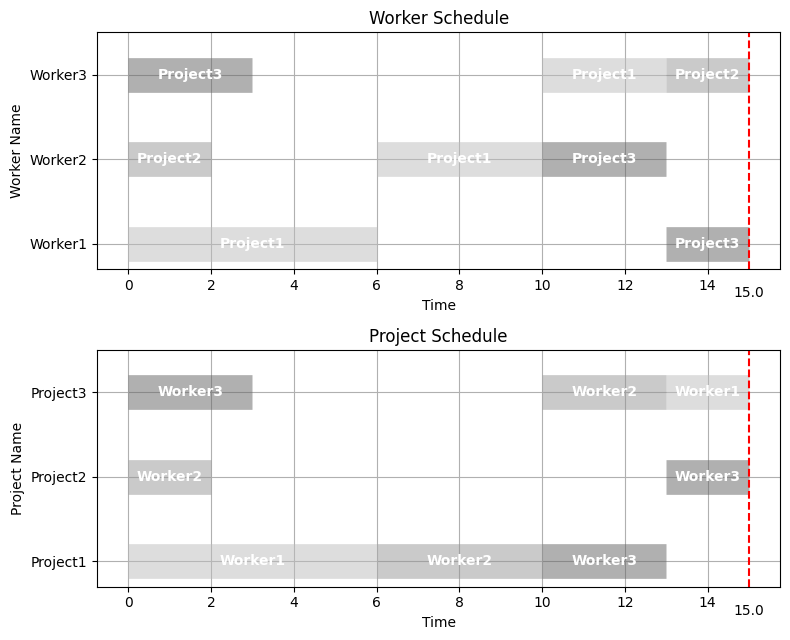

In [152]:
def visualize(results):

    schedule = pd.DataFrame(results)
    WORKERS = sorted(list(schedule['Worker Name'].unique()))
    PROJECTS = sorted(list(schedule['Project Name'].unique()))
    makespan = schedule['End'].max()

    bar_style = {'alpha':0.5, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.tab20c_r.colors

    schedule.sort_values(by=['Worker Name', 'Start'])
    schedule.set_index(['Worker Name', 'Project Name'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(8, 5+(len(WORKERS)+len(PROJECTS))/4))

    for jdx, j in enumerate(WORKERS, 1):
        for mdx, m in enumerate(PROJECTS, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'End']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)

    ax[0].set_title('Worker Schedule')
    ax[0].set_ylabel('Worker Name')
    ax[1].set_title('Project Schedule')
    ax[1].set_ylabel('Project Name')

    for idx, s in enumerate([WORKERS, PROJECTS]):
        ax[idx].set_ylim(0.7, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)

    fig.tight_layout()

visualize(results)

In [ ]:
# https://ampl.com/mo-book/notebooks/03/shift-scheduling.html
# https://www.kaggle.com/code/coder98/workforce-schedule-optimization
# https://medium.com/@laddha.rishi/queueing-up-success-revolutionize-workforce-planning-with-python-6c9d7edbb6cd
# https://community.esri.com/t5/arcgis-workforce-blog/automate-workforce-with-arcgis-api-for-python/ba-p/887570
# https://github.com/samirsaci/workforce-planning/blob/main/Linear%20Optimization%20Examples.ipynb
# https://towardsdatascience.com/modeling-and-optimization-of-a-weekly-workforce-with-python-and-pyomo-29484ba065bb
# https://github.com/JayLohokare/linear-optimization-scheduling
# https://www.researchgate.net/figure/Comparison-of-open-source-solvers-HiGHS-GLPK-and-Cbc-to-commercial-solver-Gurobi-on_fig1_360478503
# https://pypi.org/project/cheche-pm/
# https://ampl.com/mo-book/notebooks/03/shift-scheduling.html
# https://towardsdatascience.com/scheduling-with-ease-cost-optimization-tutorial-for-python-c05a5910ee0d
# https://www.kaggle.com/code/faressayah/predict-employee-absenteeism-from-work
# https://pyworkforce.readthedocs.io/en/stable/tutorials/scheduling.html
# https://softphone.pro/en/blog/2022/11/25/sla-and-asa-a-misleading-indicator-and-a-good-contact-center-hallmark/
# https://pypi.org/project/wfmplan/
# https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/04.03-Job-Shop-Scheduling.html

